# Natural Language Processing with Disaster Tweets

**Overview**

"Getting Started" kaggle competitions

https://www.kaggle.com/competitions/nlp-getting-started/overview

**Library Import**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from wordcloud import WordCloud, STOPWORDS

import gc
import re
import string
import operator
from collections import defaultdict

## Data Exploration

In [21]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [22]:
df_train.sample(15)

,id,keyword,location,text,target
100,144,accident,UK,.@NorwayMFA #Bahrain police had previously die...,1
2684,3850,detonation,NaN,Ignition Knock (Detonation) Sensor-Senso Stand...,0
5382,7680,panic,NaN,@panic awesome thanks.,0
5769,8236,riot,Seattle,Southeast Dirt Riot Series Crowns Champions: ...,0
5101,7277,nuclear%20disaster,#goingdownthetoilet Illinois,CLOSING THEIR EYES TO DISASTER! State Departm...,1
287,420,apocalypse,"Buenos Aires, Argentina",candylit: Imagine sarumi in a zombie apocalyps...,0
6350,9080,structural%20failure,Warm Heart Of Africa,@sabcnewsroom sabotage!I rule out structural f...,0
181,260,ambulance,Mumbai,If I get run over by an ambulance am I lucky? ...,0
5693,8125,rescued,The green and pleasant land.,Why weren't they taken back to Africa once res...,1
128,184,aftershock,304,'Remembering that you are going to die is the ...,0


In [23]:
df_test.sample(10)

,id,keyword,location,text
394,1274,blood,Puerto Rico,Name: Chizu\nGender: Male\nAge: 10\nHair: Red\...
698,2269,cliff%20fall,NaN,@Spencer_VH I hope you fall off a cliff
3074,10180,violent%20storm,Worldwide,Violent Forces Radio: Now Playing Torture - St...
1953,6589,inundated,Searching for Rivendell,@eliistender10 @Splats although originally an ...
754,2450,collide,NaN,Now there's only 2 days for collide!!! get sig...
2084,7000,mayhem,worldwide,@RaynbowAffair Editor In Chief @DiamondKesawn ...
2566,8564,screams,NaN,@sugayiffer SCREAMS UR SUCH A CUTE HANAYO
3155,10474,wild%20fires,NaN,WILD FIRES! http://t.co/EgrMdkXpOi
1531,5100,famine,"Dublin, Ireland.",Miners strike; Botha Apartheid SA Tutu Nobel p...
3017,9964,tsunami,NaN,omfg Johnny tsunami commercial


In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [25]:
df_train[df_train["target"] == 0]["text"].values[2]

'Summer is lovely'

In [26]:
df_train[df_train["target"] == 0]["text"].values

array(["What's up man?", 'I love fruits', 'Summer is lovely', ...,
       'These boxes are ready to explode! Exploding Kittens finally arrived! gameofkittens #explodingkittens\x89Û_ https://t.co/TFGrAyuDC5',
       'Sirens everywhere!',
       'I just heard a really loud bang and everyone is asleep great'],
      dtype=object)

In [27]:
df_train.duplicated().sum()

0

In [28]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [29]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [30]:
cols_with_null = ['keyword','location']
for col in cols_with_null:
    df_train[col] = df_train[col].fillna('no_data')
    df_train[col] = df_train[col].fillna('no_data')

In [31]:
df_train.head()

,id,keyword,location,text,target
0,1,no_data,no_data,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_data,no_data,Forest fire near La Ronge Sask. Canada,1
2,5,no_data,no_data,All residents asked to 'shelter in place' are ...,1
3,6,no_data,no_data,"13,000 people receive #wildfires evacuation or...",1
4,7,no_data,no_data,Just got sent this photo from Ruby #Alaska as ...,1


In [32]:
df_train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [33]:
print (df_train.keyword.nunique(), df_test.keyword.nunique())


222 221


### Target Class Distribution

In [34]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

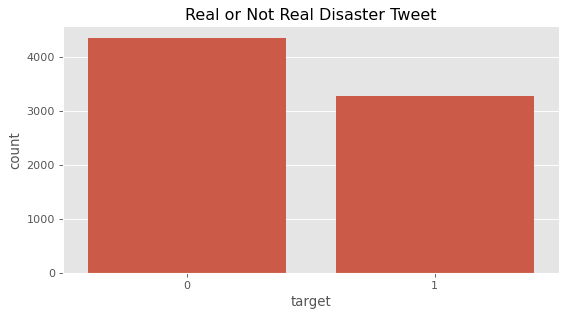

In [35]:
sns.countplot(data=df_train, x='target')
plt.title('Real or Not Real Disaster Tweet')

In [36]:
df_train['location_str'] = df_train['location'].apply(lambda x: str(x).lower().replace('$$', ' ').replace('_', ' ').replace('.', ' '))

### Most common words

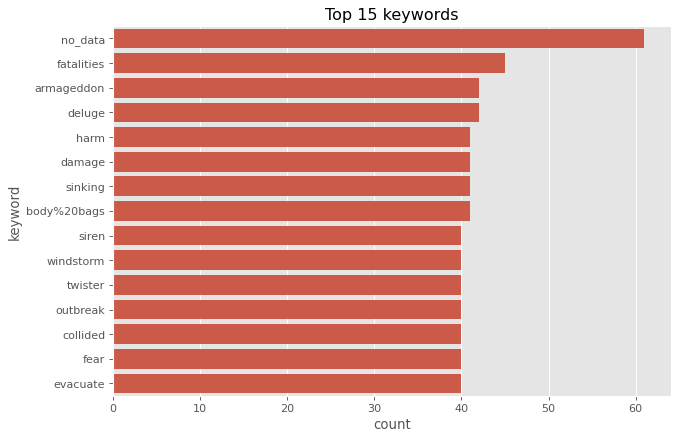

In [37]:
plt.figure(figsize=(9,6))
sns.countplot(y=df_train.keyword, order = df_train.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

### Top 10 words in disaster and non-disaster tweets


keyword
body%20bags    40
harm           37
armageddon     37
wrecked        36
deluge         36
ruin           36
fear           35
explode        35
siren          35
twister        35
Name: count, dtype: int64


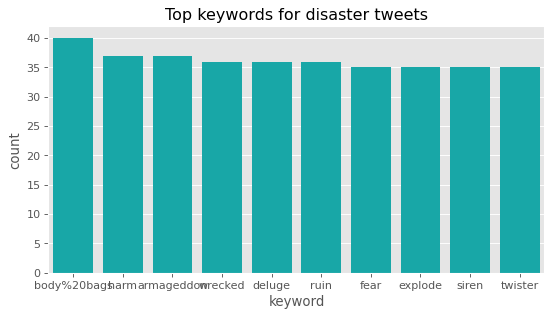

keyword
no_data              42
outbreak             39
wreckage             39
derailment           39
debris               37
typhoon              37
oil%20spill          37
evacuated            32
suicide%20bombing    32
rescuers             32
Name: count, dtype: int64


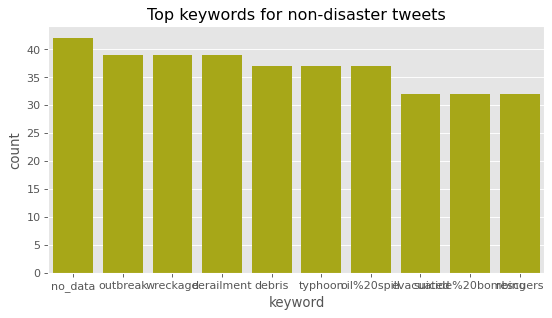

In [38]:
kw_nd = df_train[df_train.target==0].keyword.value_counts().head(10)
print(kw_nd)

sns.barplot(kw_nd, color='c')
plt.title('Top keywords for disaster tweets')
plt.show()

kw_d = df_train[df_train.target==1].keyword.value_counts().head(10)
print(kw_d)

sns.barplot(kw_d, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

### Number of Characters Distribution in Tweets

<Axes: xlabel='char_count', ylabel='Density'>

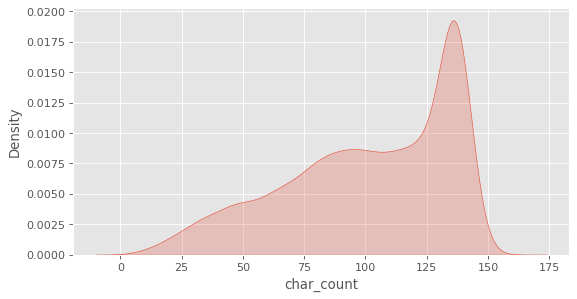

In [39]:
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
sns.kdeplot(df_train['char_count'], fill=True)

<Axes: xlabel='char_count', ylabel='Density'>

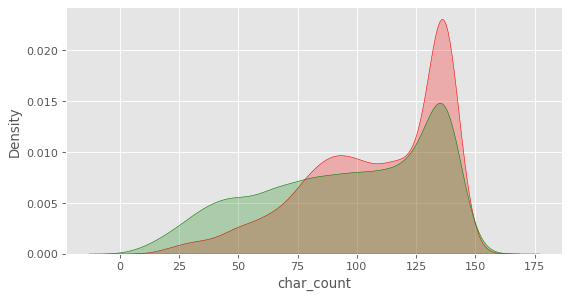

In [40]:
sns.kdeplot(df_train[df_train['target'] == 1]['char_count'], fill=True, color='red')
sns.kdeplot(df_train[df_train['target'] == 0]['char_count'], fill=True, color='green')

### Number of Characters Distribution in Tweets

<Axes: xlabel='words_count', ylabel='Density'>

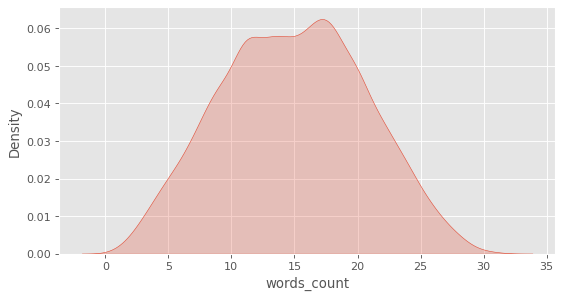

In [41]:
df_train['words_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
sns.kdeplot(df_train['words_count'], fill=True)

<Axes: xlabel='words_count', ylabel='Density'>

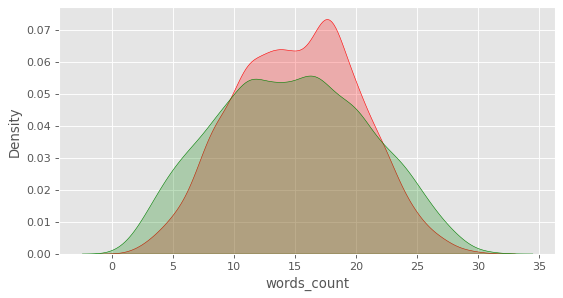

In [42]:

sns.kdeplot(df_train[df_train['target'] == 1]['words_count'], fill=True, color='red')
sns.kdeplot(df_train[df_train['target'] == 0]['words_count'], fill=True, color='green')

### Unique words

<Axes: xlabel='unique_word_count', ylabel='Density'>

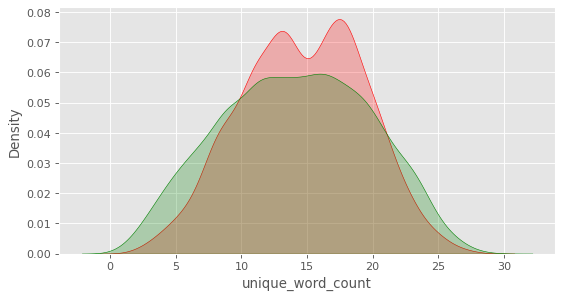

In [43]:
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
sns.kdeplot(df_train[df_train['target'] == 1]['unique_word_count'], fill=True, color='red')
sns.kdeplot(df_train[df_train['target'] == 0]['unique_word_count'], fill=True, color='green')

### Stop words


<Axes: xlabel='stop_word_count', ylabel='Density'>

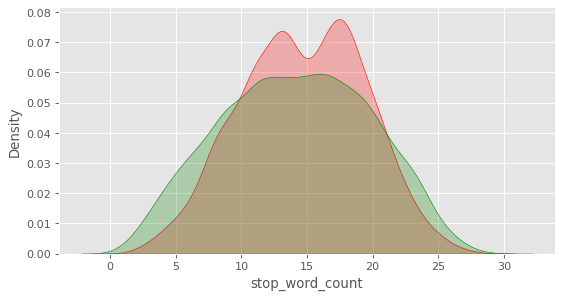

In [44]:
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
sns.kdeplot(df_train[df_train['target'] == 1]['stop_word_count'], fill=True, color='red')
sns.kdeplot(df_train[df_train['target'] == 0]['stop_word_count'], fill=True, color='green')

### Hashtag count


<Axes: xlabel='hashtag_count', ylabel='Density'>

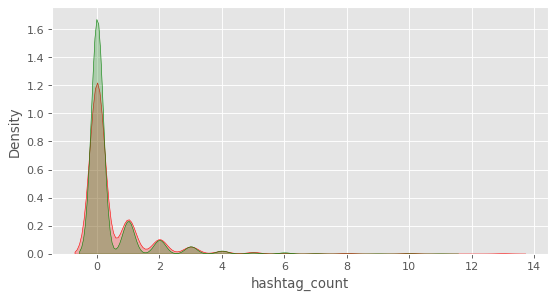

In [45]:
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([hashtag for hashtag in str(x) if hashtag == '#']))
sns.kdeplot(df_train[df_train['target'] == 1]['hashtag_count'], fill=True, color='red')
sns.kdeplot(df_train[df_train['target'] == 0]['hashtag_count'], fill=True, color='green')

## Preprocessing and Cleaning 

In [46]:
df_train['text'] = df_train['text'].apply(lambda x: str(x).lower())
df_test['text'] = df_train['text'].apply(lambda x: str(x).lower())

In [47]:
df_train['text']

0       our deeds are the reason of this #earthquake m...
1                  forest fire near la ronge sask. canada
2       all residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       just got sent this photo from ruby #alaska as ...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @thetawniest the out of control w...
7610    m1.94 [01:04 utc]?5km s of volcano hawaii. htt...
7611    police investigating after an e-bike collided ...
7612    the latest: more homes razed by northern calif...
Name: text, Length: 7613, dtype: object

In [48]:
df_test['text']

0       our deeds are the reason of this #earthquake m...
1                  forest fire near la ronge sask. canada
2       all residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       just got sent this photo from ruby #alaska as ...
                              ...                        
3258    do you feel engulfed with low self-image? take...
3259    man is equally incapable of seeing the nothing...
3260    fully engulfed garage fire: propane tanks insi...
3261    he came to a land which was engulfed in tribal...
3262    @suelinflower there is no words to describe th...
Name: text, Length: 3263, dtype: object

### Load GloVe Vector 

In [49]:
glove_vectors = dict()

In [50]:
file = open('glove/glove.6B.100d.txt', encoding='utf-8')

for line in file:
    values = line.split()
    
    word  = values[0]
    vectors = np.asarray(values[1:])
    glove_vectors[word] = vectors
    
file.close()

In [ ]:
# glove_vectors

### Text to GloVe Vectors 

In [52]:
vec_shape = 100

def get_vec(x):
    arr = np.zeros(vec_shape)
    text = str(x).split()
    
    for t in text:
        try:
            vec = glove_vectors.get(t).astype(float)
            arr = arr + vec
        except:
            pass
        
    arr = arr.reshape(1, -1)[0]
    return arr/len(text)

x = 'gafa'

def build_vocab(X):
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    # sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return vocab_coverage, text_coverage



In [53]:
train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text'], glove_vectors)
test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text'], glove_vectors)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

GloVe Embeddings cover 39.80% of vocabulary and 78.64% of text in Training Set
GloVe Embeddings cover 46.94% of vocabulary and 78.89% of text in Test Set


### Improve Text to GloVe Vectors After Cleaning

In [54]:
# Reference: https://github.com/MahalavanyaSriram/Natural-Language-Processing-with-Disaster-Tweets/blob/master/Jupyter%20Notebooks/disaster-tweets-eda-topic-modeling-lstm-bert.ipynb
def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
    return tweet

In [55]:
# removing special characters and numbers
df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean(s))
df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean(s))

In [56]:
train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], glove_vectors)
test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], glove_vectors)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

GloVe Embeddings cover 71.65% of vocabulary and 95.01% of text in Training Set
GloVe Embeddings cover 76.87% of vocabulary and 94.89% of text in Test Set


In [57]:
df_train['vec'] = df_train['text'].apply(lambda x: get_vec(x))
df_test['vec'] = df_train['text'].apply(lambda x: get_vec(x))


In [58]:
df_train['vec']

0       [0.022177076923076928, 0.27797830769230775, 0....
1       [-0.09050485714285712, -0.2712157142857143, 0....
2       [-0.017607409090909076, 0.17308627272727273, 0...
3       [0.245866625, 0.275276625, 0.00756562500000000...
4       [0.0046112437500000075, 0.18196333124999997, 0...
                              ...                        
7608    [0.07085272727272728, 0.2873204545454545, -0.0...
7609    [-0.15719479999999997, -0.06036769999999999, 0...
7610    [-0.034623749999999995, 0.10597499999999999, 0...
7611    [0.055600157894736844, -0.15937647368421057, 0...
7612    [-0.20643718461538466, 0.04325961538461539, 0....
Name: vec, Length: 7613, dtype: object

In [59]:
df_train.head()

,id,keyword,location,text,target,location_str,char_count,words_count,unique_word_count,stop_word_count,hashtag_count,text_cleaned,vec
0,1,no_data,no_data,our deeds are the reason of this #earthquake m...,1,no data,69,13,13,13,1,our deeds are the reason of this # earthquake...,"[0.022177076923076928, 0.27797830769230775, 0...."
1,4,no_data,no_data,forest fire near la ronge sask. canada,1,no data,38,7,7,7,0,forest fire near la ronge sask . canada,"[-0.09050485714285712, -0.2712157142857143, 0...."
2,5,no_data,no_data,all residents asked to 'shelter in place' are ...,1,no data,133,22,20,20,0,all residents asked to ' shelter in place ' ...,"[-0.017607409090909076, 0.17308627272727273, 0..."
3,6,no_data,no_data,"13,000 people receive #wildfires evacuation or...",1,no data,65,8,8,8,1,"13,000 people receive # wildfires evacuation ...","[0.245866625, 0.275276625, 0.00756562500000000..."
4,7,no_data,no_data,just got sent this photo from ruby #alaska as ...,1,no data,88,16,15,15,2,just got sent this photo from ruby # alaska a...,"[0.0046112437500000075, 0.18196333124999997, 0..."


## ML Model Building, Training, and Testing

In [60]:
X_train = df_train['vec']
X_train

0       [0.022177076923076928, 0.27797830769230775, 0....
1       [-0.09050485714285712, -0.2712157142857143, 0....
2       [-0.017607409090909076, 0.17308627272727273, 0...
3       [0.245866625, 0.275276625, 0.00756562500000000...
4       [0.0046112437500000075, 0.18196333124999997, 0...
                              ...                        
7608    [0.07085272727272728, 0.2873204545454545, -0.0...
7609    [-0.15719479999999997, -0.06036769999999999, 0...
7610    [-0.034623749999999995, 0.10597499999999999, 0...
7611    [0.055600157894736844, -0.15937647368421057, 0...
7612    [-0.20643718461538466, 0.04325961538461539, 0....
Name: vec, Length: 7613, dtype: object

In [77]:
X_train = np.concatenate(X_train, axis = 0).reshape(-1, vec_shape)

In [78]:
vec_shape = 100
X_train = np.concatenate(X_train, axis = 0).reshape(-1, vec_shape)
X_train.shape

(6090, 100)

In [79]:
X_test = df_test['vec']
print(X_test.shape)
X_test= np.concatenate(X_test, axis = 0).reshape(-1, vec_shape)
print(X_test.shape)

(3263,)
(3263, 100)


In [64]:
y_train = df_train['target']

### Logistic Regression

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix

In [80]:
clf = LogisticRegression(solver = 'liblinear', multi_class='auto')

In [81]:
clf.fit(X_train, y_train)

/localdisk/jafraust/miniforge/envs/nlp_tweets/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='auto', solver='liblinear')

In [83]:
y_pred = clf.predict(X_test)

### Save CSV

In [84]:
output = pd.DataFrame(y_pred, columns=['target'])

In [85]:
output.head()

,target
0,0
1,1
2,1
3,1
4,0


In [86]:
frames = [df_test['id'], output]
result = pd.concat(frames, axis=1, join='inner')
result.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,0


In [87]:
result.to_csv('submission.csv', index=False)

### Logistic Regression only with Train Dataset

In [88]:
X = X_train # test dataframe does not have target column
y = y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [89]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81       695
           1       0.75      0.70      0.73       523

    accuracy                           0.77      1218
   macro avg       0.77      0.76      0.77      1218
weighted avg       0.77      0.77      0.77      1218



/localdisk/jafraust/miniforge/envs/nlp_tweets/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Support Vector Machine

In [90]:
from sklearn.svm import LinearSVC

In [91]:
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC()

In [92]:
y_pred = clf.predict(X_test)

In [93]:
import pickle

In [94]:
pickle.dump(clf, open('model_svm.pkl', 'wb'))

## Predict Text Emotion with Custom Data 

In [95]:
model = pickle.load(open('model_svm.pkl', 'rb'))

In [96]:
x = 'this is an awesome adventure'

In [97]:
def get_pred(x):
    vec = get_vec(x).reshape(-1, vec_shape)
    
    emotion = model.predict(vec)
    
    return emotion

In [98]:
get_pred(x)

array([0])